# Preprocemento - Dataset 2

## Imports

In [1]:
import os
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib as mpl
from sklearn import cluster, datasets, mixture
import matplotlib.pyplot as plt
import random

## Setting random seeds

Força inicialização das tabelas pseudo aleatórias a fim de se ter repetibilidade nos tests

In [2]:
np.random.seed(1)
random.seed(1)

## Leitura dos dados e armazenamento em DataFrame Pandas

In [3]:
dataPath = r'D:\14--OneDrive\OneDrive\ML-SEA-2021\Rede_Teste_2' # modificar este caminho para o local dos dados no seu computador
npzFname = 'dataset_v1_lhs10000_sw_ar_sweep_static_thrust_climb_cas_climb_mach_cruise_mach_cruise_alt.npz'

npz = np.load(os.path.join(dataPath, npzFname))

### Conversão para DataFrame

In [4]:
df = pd.DataFrame(npz['data'], columns=npz['columns'])
df

,sw,ar,sweep,static_thrust,climb_cas,climb_mach,cruise_mach,cruise_alt,tow,bow,w_fuel,d_mission,t_mission,actual_cruise_alt
0,194.823630,7.360936,17.373816,20661.096888,231.575250,0.627542,0.734908,40000.0,97641.388027,50334.459178,23342.728491,2002.132299,297.459321,40000.0
1,81.301558,10.054927,30.484605,20192.697571,281.476898,0.476120,0.808958,37000.0,101331.660616,48517.882870,28860.451348,2007.124707,267.621831,28000.0
2,86.326998,12.685777,29.887247,25953.375056,260.604176,0.512460,0.795209,35000.0,88412.320723,50753.204581,13685.252946,2003.697056,273.954191,35000.0
3,168.740149,8.874556,27.865347,22335.012832,248.575052,0.548278,0.830269,42000.0,95947.594683,51064.932172,20907.014703,2003.382701,268.710513,42000.0
4,164.268862,13.596071,32.761112,21714.200445,227.471505,0.468596,0.762408,35000.0,91217.031484,51929.187517,15312.379094,2003.829909,286.278288,35000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,162.916604,10.978954,17.980150,21419.519553,250.947880,0.468477,0.706156,32000.0,88179.943622,50624.046608,13570.746369,2002.816497,301.949762,32000.0
9996,80.943532,9.530193,24.484502,23375.400645,251.672504,0.458090,0.731658,42000.0,93607.602981,49355.913089,20224.984434,1988.837391,292.232128,31000.0
9997,156.408388,8.373778,23.454672,25946.091538,245.128100,0.639984,0.708192,36000.0,90313.646599,51680.869175,14661.186790,2003.489853,304.994295,36000.0
9998,117.889398,8.429739,20.863204,27166.808527,234.176214,0.568794,0.765726,41000.0,92046.247063,51176.297973,16908.689538,2003.114890,285.771053,41000.0


## Tratamento dos dados

### Remoção de NaN's

In [5]:
df.dropna(axis='rows', inplace=True)
len(df)

9984

### Limpeza dos dados

In [7]:
w_fuel = df.loc[:, 'w_fuel'].values
cruise_alt = df.loc[:, 'cruise_alt'].values
actual_cruise_alt = df.loc[:, 'actual_cruise_alt'].values

w_fuel_max = np.percentile(w_fuel, 95) * 2.0
print('{:.0f}kg'.format(w_fuel_max))

print(df.loc[:, 'w_fuel'].count())

df2 = df.loc[(df.loc[:, 'w_fuel']<w_fuel_max) & (np.abs(df.loc[:, 'cruise_alt']-df.loc[:, 'actual_cruise_alt'])<1000)]

print(df2.loc[:, 'w_fuel'].count())

df2 = df2.loc[(df2.loc[:, 'w_fuel']<w_fuel_max)]

#df2 = df.loc[(df.loc[:, 'w_fuel']<w_fuel_max) & ((df.loc[:, 'cruise_alt']-df.loc[:, 'actual_cruise_alt'])<500)]

print(df2.loc[:, 'w_fuel'].count())

54262kg
9984
8375
8375


### Gráfico com visualização 3D da saída versus as duas principais entradas

<AxesSubplot:xlabel='sw', ylabel='ar'>

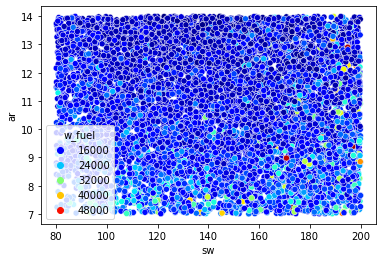

In [8]:
cmap = mpl.cm.get_cmap('jet')
sns.scatterplot(data=df2, x="sw", y="ar", hue='w_fuel', palette=cmap)

### Remoção de outliers utilizando Gaussian Mixture Model

<AxesSubplot:xlabel='sw', ylabel='w_fuel'>

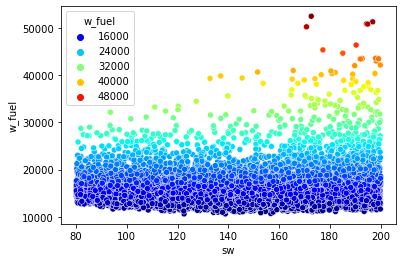

In [9]:
sns.scatterplot(data=df2, x="sw", y='w_fuel', hue='w_fuel', palette=cmap)

In [10]:
#df2 = df

In [11]:
gmm = mixture.GaussianMixture(
        n_components=8, covariance_type='full')
gmm_data = df2.loc[:,['sw','w_fuel']].values

gd_max = np.max(gmm_data, axis=0)
gd_min = np.min(gmm_data, axis=0)
gd_scale = gd_max - gd_min
gmm_data = (gmm_data - gd_min) * (1 / gd_scale)
gmm.fit(gmm_data)
y_pred = gmm.predict(gmm_data)

In [12]:
y_score = gmm.score_samples(gmm_data)
y_threshold = np.percentile(y_score, 0.2)

df3 = df2.loc[y_score >= y_threshold]

df_outlier = df2.loc[y_score < y_threshold]

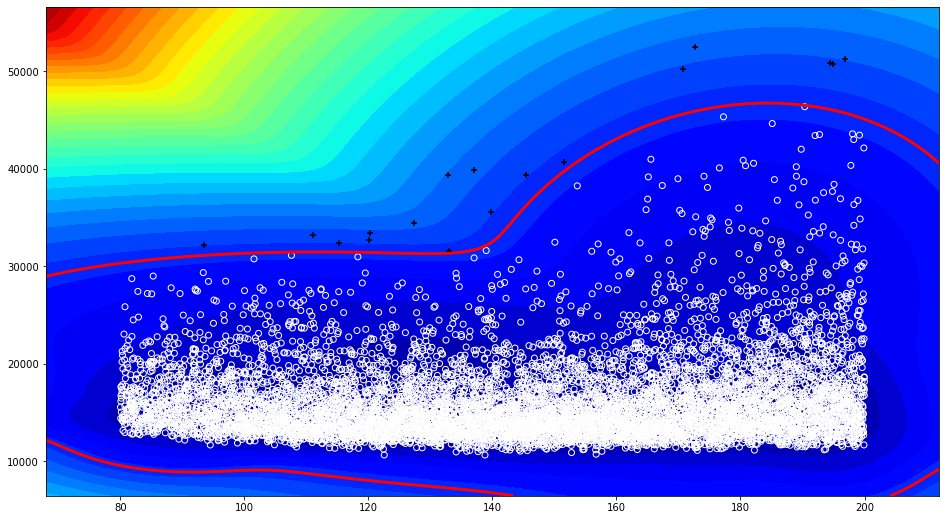

In [13]:
X, Y = np.meshgrid(np.linspace(-0.1,1.1,num=100), np.linspace(-0.1,1.1,num=100))
XX = np.array([X.ravel(), Y.ravel()]).T
Z = gmm.score_samples(XX)

Z = Z.reshape((100,100))

X = X * gd_scale[0] + gd_min[0]
Y = Y * gd_scale[1] + gd_min[1]

fig, ax = plt.subplots(figsize=(16,9))

ax.contourf(X, Y,Z, cmap='jet_r', levels=45)

ax.scatter(df_outlier.loc[:,'sw'].values, df_outlier.loc[:, 'w_fuel'], color='k', facecolor='k', marker='+')

ax.scatter(df3.loc[:,'sw'].values, df3.loc[:, 'w_fuel'], color='white', facecolor='None', marker='o')

ax.contour(X, Y,Z, colors='r', levels=[y_threshold], linestyles='-', linewidths=3.0)


<AxesSubplot:xlabel='sw', ylabel='w_fuel'>

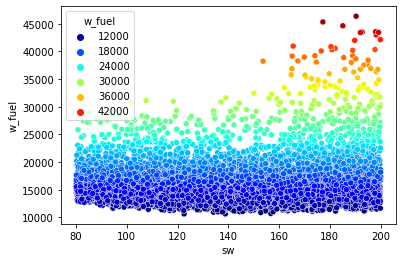

In [14]:
sns.scatterplot(data=df3, x="sw", y='w_fuel', hue='w_fuel', palette=cmap)

## Seleção das features, labels e segmentação do dataset

In [52]:
features = ['sw', 'ar', 'sweep', 'static_thrust', 'climb_cas', 'climb_mach', 'cruise_mach', 'cruise_alt']
#labels = ['tow', 'bow', 'w_fuel', 'd_mission', 't_mission', 'actual_cruise_alt']
labels = ['tow', 'bow', 'w_fuel', 't_mission', 'actual_cruise_alt']
df_features = df3.loc[:, features]
df_labels = df3.loc[:, labels]

X_ALL = df_features.values
Y_ALL = df_labels.values

m_avail = X_ALL.shape[0]
print('Available number of samples: {}'.format(m_avail))

Available number of samples: 8358


In [53]:
Y_ALL.shape

(8358, 5)

In [54]:
m_test = 250
m_train = X_ALL.shape[0] - m_test

idxs = np.arange(m_avail)
np.random.shuffle(idxs)

X_ALL = X_ALL[idxs, :]
Y_ALL = Y_ALL[idxs, :]

X_TRAIN = X_ALL[:m_train, :]
Y_TRAIN = Y_ALL[:m_train, :]

X_TEST = X_ALL[:m_train, :]
Y_TEST = Y_ALL[:m_train, :]

np.savez(os.path.join(dataPath, 'training_data.npz'), X_TRAIN=X_TRAIN, Y_TRAIN=Y_TRAIN, X_TEST=X_TEST, Y_TEST=Y_TEST)